In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import calendar
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock
from warnings import filterwarnings
filterwarnings('ignore')

c = calendar.Calendar(firstweekday=calendar.SUNDAY)

def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

# def new_next_exp(today):

#     today = dt.datetime.strptime(today, '%Y-%m-%d')

#     next_mon = today + relativedelta.relativedelta(months=1)
#     nnext_mon = next_mon + relativedelta.relativedelta(months=1)

#     if today.day < 15:
#         result = next_mon
#     else:
#         result = nnext_mon
        
#     return result.strftime("%Y%m")

def next_opt_exp(today):

    year = today.year
    month = today.month
    monthcal = c.monthdatescalendar(year,month)
    second_thursday = [day for week in monthcal for day in week if \
                day.weekday() == calendar.THURSDAY and \
                day.month == month][1]

    if today.day<second_thursday.day:
        result= second_thursday
    else:
        result=second_thursday+ relativedelta.relativedelta(months=1)

    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))

def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k

def d1_cal (s, k, r, q, vol, t):
    return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

def d2_cal (s, k, r, q, vol, t):
    return d1_cal(s, k, r, q, vol, t) - vol * np.sqrt(t)    

def gamma_cal (s, k, r, q, vol, t):
    
    return norm.pdf(d1_cal(s, k, r, q, vol, t)) / (s*vol*np.sqrt(t))

def theta_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''

    p1 = - s * norm.pdf(d1_cal(s, k, r, q, vol, t))*vol / (2 * np.sqrt(t))
    p2 = r * k * np.exp(-r*t) * norm.cdf(d2_cal(s, k, r, q, vol, t)) 

    if type == 'c':
        return p1 - p2
    else:
        return p1 + p2
    
def vega_cal (s, k, r, q, vol, t):
    return s * np.sqrt(t) * norm.pdf(d1_cal(s,k,r,q,vol,t))

def rho_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''
    if type =='c':
        return k*t*np.exp(-r*t)*norm.cdf(d2_cal(s, k, r, q, vol, t))
    else:
        return -k*t*np.exp(-r*t)*norm.cdf(-d2_cal(s, k, r, q, vol, t))
    
def tmp_dist(price_lst,strike_lst):
    
    window_price = sliding_window_view(price_lst, 3)
    window_strike = sliding_window_view(strike_lst, 3)
    distance = (abs(window_strike[:,2]-window_strike[:,1])+abs(window_strike[:,1]-window_strike[:,0]))/2
    result=window_price[:,0]+window_price[:,2]-2*window_price[:,1]
    return np.round(((result/(distance**2))), 5)

def cal_cost(df):
    return df.iloc[0].item() + df.iloc[2].item() - 2 * df.iloc[1].item()

# 전처리

In [2]:
file_path = os.getcwd() + '/Data/'

kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']
kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [float(x[7:]) for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [3]:
'''코스피'''
kospi_idx = kospi200.loc['2007-12-03':'2022-10-17'].index
idx = kospi_idx[2]
s0 = kospi200.loc[idx]

# 거래기록 Count

In [67]:
count = 0
countp = 0
for num in tqdm(range(len(kospi_idx))):
    try:
        idx = kospi_idx[0]
        s0 = kospi200.loc[idx]
        '''전처리용 데이터'''
        test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''otm 가격'''
        otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(test, s0, -0.08)
        atm_k = atm_mapping(test, s0)

        '''Strike range 잡기'''
        k_list_c = test.columns.get_level_values(2).unique().values
        k_list_p = testp.columns.get_level_values(2).unique().values

        k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
        k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

        kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
        kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


        '''임볼 그리기'''
        kk = test.columns.get_level_values(2)
        kk_p = kk[np.where((kk < atm_k))]
        kk_c = kk[np.where((kk >= atm_k))]
        iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
        iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

        # plt.figure(figsize=(5,5))
        # plt.plot(iv_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=iv_tmp.index, y=iv_tmp)
        # plt.legend()
        # plt.show()

        '''가격 그래프'''
        pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
        pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
        # plt.figure(figsize=(5,5))
        # plt.plot(pr_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=pr_tmp.index, y=pr_tmp)
        # plt.legend()
        # plt.show()


        '''port 구성 잡기'''
        port_comb = sliding_window_view(k_list_c, 3)
        port_comb_p = sliding_window_view(k_list_p, 3)

        '''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
        g_list = tmp_dist(kp_list_c, k_list_c)
        g_list_p = tmp_dist(kp_list_p, k_list_p)


        g_list_p
        '''진입은 > -일때 진입
        청산 > 다음 위치가 + 일때 청산

        각각의 포트폴리오는, sliding window로 만든것 중에서, 앞뒤 롱, 가운데 숏임 / 아니면 숏숏롱'''
        if (g_list<0).sum() != 0:
            count += (g_list<0).sum()
        else:
            pass
        if (g_list_p<0).sum() != 0:
            countp += (g_list_p<0).sum()
        else:
            pass

    except:
        print(kospi_idx[num])
        pass


100%|██████████| 3674/3674 [02:12<00:00, 27.71it/s]


# 백테스트용 사전 p_reg, g_reg 뽑기

In [154]:
g_reg = pd.DataFrame()
p_reg = pd.DataFrame()
p_all_reg = pd.DataFrame()
iv_reg = pd.DataFrame()

for num in tqdm(range(len(kospi_idx))):
#for num in tqdm(range(1900, 3674)):
    
    idx = kospi_idx[num]
    s0 = kospi200.loc[idx]    

    '''전처리용 데이터'''
    test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''otm 가격'''
    # otm_k_c = otm_mapping(test, s0, 0.08)
    # otm_k_p = otm_mapping(test, s0, -0.08)
    atm_k = atm_mapping(test, s0)

    kk = test.columns.get_level_values(2)
    kk_p = kk[np.where((kk < atm_k))]
    kk_pa = kk[np.where((kk < atm_k * 1.2))] 
    kk_c = kk[np.where((kk >= atm_k))]

    iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
    iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

    pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
    pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])

    pr_tmp_all = pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_pa, '종가')])
    pr_tmp_all = pd.DataFrame(data=pr_tmp_all.values, index=pr_tmp_all.index.get_level_values(2).values, columns=[idx])
    
    test_put_iv = iv_tmp[iv_tmp.index <= atm_k]
    test_put_price = pr_tmp[pr_tmp.index <= atm_k]

    #port_comb_c = sliding_window_view(k_list_c, 3)
    port_comb_p = sliding_window_view(test_put_iv.index, 3)
    g_values = tmp_dist(test_put_price.astype(float).to_numpy().reshape(-1), test_put_price.index)

    '''Strike range 잡기'''
    # k_list_c = test.columns.get_level_values(2).unique().values
    # k_list_p = testp.columns.get_level_values(2).unique().values

    # k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
    # k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

    # kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
    # kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values

    '''이때, 하나 줄이기'''
    #g_reg = pd.concat([g_reg, pd.DataFrame(g_values, index=port_comb_p[:,0], columns=[idx])], axis=1)
    g_reg = pd.concat([g_reg, pd.DataFrame(g_values[:-1], index=port_comb_p[:-1,0], columns=[idx])], axis=1).sort_index()
    p_reg = pd.concat([p_reg, test_put_price.sort_index(ascending=True)], axis=1).sort_index()
    p_all_reg = pd.concat([p_all_reg, pr_tmp_all.sort_index(ascending=True)], axis=1).sort_index()
    iv_reg = pd.concat([iv_reg, test_put_iv.sort_index(ascending=True)], axis=1).sort_index()

100%|██████████| 3674/3674 [03:49<00:00, 16.03it/s]


# 백테스팅

In [252]:
cost_df = pd.DataFrame()
pnl_df = pd.DataFrame()
eq_pnl_df = pd.DataFrame()

pnl = pd.DataFrame(index=g_reg.columns, columns=['cost', 'path'])
port = []
possible_inst = sliding_window_view(g_reg.index, 3)
holding_p = []
budget = 10000
budget_df = pd.DataFrame(columns=['budget'])

init_position_date = 0
holding_position_date = 0

#for inv_idx in tqdm(g_reg.columns[-2000:-1990]):
for inv_idx in tqdm(g_reg.columns[-1816:]):    
#for inv_idx in tqdm(g_reg.columns[3030 : 3040]):
        
    try:
        
        idx = inv_idx
        s0 = kospi200.loc[idx]    

        # print(idx)
        # print(holding_p)
    

        '''필요 df'''
        check = g_reg[idx]
        p_check = p_reg[idx]
        #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''1. k범위 정하기'''
        #otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(testp, s0, -0.08)
        atm_k = atm_mapping(testp, s0)

        '''1. 들고 있는 포지션 있는지 확인하기'''
        '''holding_p에 데이터 있는지 확인'''
        if holding_p == []:
            pass
        
        else:
            holding_position_date += 1
            pnl_ch = 0
            eq = len(holding_p)
            for port in holding_p:
                '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                 
                if pd.isna(tmp_cost) is False:
                    pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                    budget += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                else:
                    
                    tmp_possible_inst = sliding_window_view(p_all_reg.index, 3)
                    tmp_p_check = p_all_reg[idx]
                    
                    pnl_ch += cal_cost(pd.DataFrame(tmp_p_check.loc[tmp_possible_inst[np.where(tmp_possible_inst[:,0] == port)][0]]))
                    budget += cal_cost(pd.DataFrame(tmp_p_check.loc[tmp_possible_inst[np.where(tmp_possible_inst[:,0] == port)][0]]))
            
            if pnl_ch < -4 :     
                # print(idx)   
                # print(pnl_ch)
                # print(holding_p)
                # print('---------------------')
                for port in holding_p:
                    '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                    # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                    tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                    print(port)
                    print(tmp_cost)
                    if pd.isna(tmp_cost) is False:
                        pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                        budget += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                    else:
                        
                        tmp_possible_inst = sliding_window_view(p_all_reg.index, 3)
                        tmp_p_check = p_all_reg[idx]
                        
                        pnl_ch += cal_cost(pd.DataFrame(tmp_p_check.loc[tmp_possible_inst[np.where(tmp_possible_inst[:,0] == port)][0]]))
                        budget += cal_cost(pd.DataFrame(tmp_p_check.loc[tmp_possible_inst[np.where(tmp_possible_inst[:,0] == port)][0]]))
                
                
            else:
                pass
            pnl_df.loc[idx, 'pnl'] = pnl_ch
            eq_pnl_df.loc[idx, 'pnl'] = pnl_ch / eq

            '''청산 체크'''
            for port in holding_p:
                if g_reg.loc[port, idx] >= 0 or pd.isna(g_reg.loc[port, idx]) == True:          
                    del holding_p[np.where(np.array(holding_p)==port)[0][0]]
                else:
                    pass
        
        '''2. 신규 들고갈 포지션 잡기'''
        new_position_check = check.iloc[np.where(check.index >= otm_k_p)]

        if (new_position_check < 0).sum() == 0:
            
            # new_cost = pd.DataFrame(data=np.zeros(1), index=['cost'], columns=[idx]).T
            # cost_df = pd.concat([cost_df, new_cost], axis=0)
            pass
            
        else:

            today_new_position = pd.DataFrame(new_position_check.iloc[np.where(new_position_check < 0)])

            tmp_cost = 0

            for new_port_idx in today_new_position.index:
                
                init_position_date += 1
                # if new_port_idx in holding_p:
                #     pass
                
                # else:
                aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3])
                tmp_cost += -cal_cost(aa)
                
                '''버젯에 추가 됨 -이면 돈받고 물건 산거고, +면 돈 내고 물건을 산거임'''
                budget += -cal_cost(aa)
                
                #aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3]).to_numpy()
                    
                #for values in today_new_position.index:
                holding_p.append(new_port_idx)
                
            new_cost = pd.DataFrame(data=tmp_cost, index=['cost'], columns=[idx]).T

            cost_df = pd.concat([cost_df, new_cost], axis=0)
            
            new_holding_portfolio = today_new_position.index.to_list()

                    
        '''3. 현재 들고 있는 포지션에 추가하기'''
        if 'new_holding_portfolio' in locals():
            pnl.loc[idx]['cost'] = new_cost.values[0][0]
            del new_holding_portfolio
        else:
            pass

        budget_df.loc[idx, 'budget'] = budget    
    except:
        pass

Nominal_PNL_df = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])

all_date_df = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])


 89%|████████▉ | 1617/1816 [00:20<00:03, 56.17it/s]

392.5
-4.84


100%|██████████| 1816/1816 [00:24<00:00, 74.87it/s]


In [253]:
print('# Holding Dates :', holding_position_date + init_position_date)
print('# Init Trade Dates :', init_position_date)


# Holding Dates : 900
# Init Trade Dates : 458


In [254]:
Nominal_PNL_df.iloc[np.where(Nominal_PNL_df<-1)[0]]

,PNL
2020-03-18,-2.95
2021-12-10,-9.66


In [291]:
kospi200.loc['2020':].mean()

348.9323439667128

In [296]:
p_reg.loc['2020':].loc[340].dropna().mean()

0.6999687500000003

In [297]:
0.69*4*250000

690000.0

In [278]:
g_reg['2020-03-17'].dropna()

192.5   -0.0160
195.0    0.0080
197.5    0.0208
200.0   -0.0144
202.5    0.0176
205.0    0.0048
207.5    0.0144
210.0   -0.0160
212.5    0.0240
215.0    0.0080
217.5    0.0080
Name: 2020-03-17 00:00:00, dtype: float64

In [282]:
5.89 * 250000 * 4

5890000.0

In [276]:
p_reg['2020-03-17'].dropna()

192.5     5.89
195.0     6.52
197.5     7.05
200.0     7.63
202.5     8.34
205.0     8.96
207.5     9.69
210.0    10.45
212.5     11.3
215.0    12.05
217.5    12.95
220.0     13.9
222.5     14.9
225.0     16.2
Name: 2020-03-17 00:00:00, dtype: object

In [279]:
10.45 + 12.05  - 22.6

-0.10000000000000142

In [263]:
p_reg['2020-03-18'].dropna()

187.5     7.22
190.0     7.81
192.5     8.41
195.0     9.09
197.5      9.8
200.0    10.55
202.5    11.35
205.0     12.2
207.5    13.15
210.0    14.05
212.5    15.05
215.0       13
Name: 2020-03-18 00:00:00, dtype: object

In [280]:
14.05 + 13 - 30.1

-3.0500000000000007

In [267]:
p_all_reg['2020-03-19'].dropna()

175.0     7.07
177.5     7.74
180.0     8.56
182.5     9.32
185.0    10.25
187.5     11.1
190.0     11.9
192.5    12.85
195.0     13.9
197.5     14.9
200.0       16
202.5     17.2
205.0    18.25
207.5     19.7
210.0    21.05
212.5    22.35
215.0     24.1
217.5     26.1
220.0     27.7
222.5    29.35
225.0    31.15
227.5    33.35
230.0       35
232.5     37.6
235.0     38.7
Name: 2020-03-19 00:00:00, dtype: object

In [268]:
21.05 + 24.1 - 44.7

0.45000000000000284

In [275]:
g_reg['2021-12-10'].dropna()

292.5    0.0016
295.0    0.0000
297.5    0.0000
300.0   -0.0016
302.5    0.0016
305.0    0.0000
307.5    0.0000
310.0    0.0000
312.5    0.0000
315.0    0.0016
317.5   -0.0016
320.0    0.0016
322.5    0.0000
325.0    0.0000
327.5   -0.0016
330.0    0.0048
332.5   -0.0016
335.0    0.0016
337.5    0.0016
340.0   -0.0016
342.5    0.0032
345.0    0.0048
347.5   -0.0048
350.0    0.0096
352.5   -0.0048
355.0    0.0096
357.5    0.0016
360.0    0.0032
362.5    0.0080
365.0    0.0048
367.5    0.0176
370.0   -0.0032
372.5    0.0176
375.0    0.0080
377.5    0.0096
380.0    0.0256
382.5    0.0096
385.0    0.0176
387.5    0.0240
390.0    0.0224
Name: 2021-12-10 00:00:00, dtype: float64

In [274]:
p_reg['2021-12-10'].dropna()


292.5    0.06
295.0    0.06
297.5    0.07
300.0    0.08
302.5    0.09
305.0    0.09
307.5     0.1
310.0    0.11
312.5    0.12
315.0    0.13
317.5    0.14
320.0    0.16
322.5    0.17
325.0    0.19
327.5    0.21
330.0    0.23
332.5    0.24
335.0    0.28
337.5    0.31
340.0    0.35
342.5     0.4
345.0    0.44
347.5     0.5
350.0    0.59
352.5    0.65
355.0    0.77
357.5    0.86
360.0    1.01
362.5    1.17
365.0    1.35
367.5    1.58
370.0    1.84
372.5    2.21
375.0    2.56
377.5    3.02
380.0    3.53
382.5     4.1
385.0    4.83
387.5    5.62
390.0    6.52
392.5    7.57
395.0    8.76
397.5    5.11
Name: 2021-12-10 00:00:00, dtype: object

<AxesSubplot:>

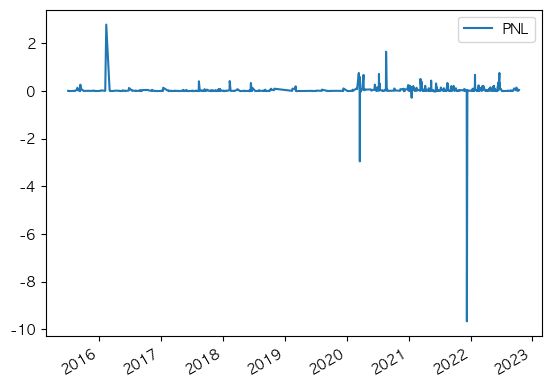

In [269]:
Nominal_PNL_df.plot()

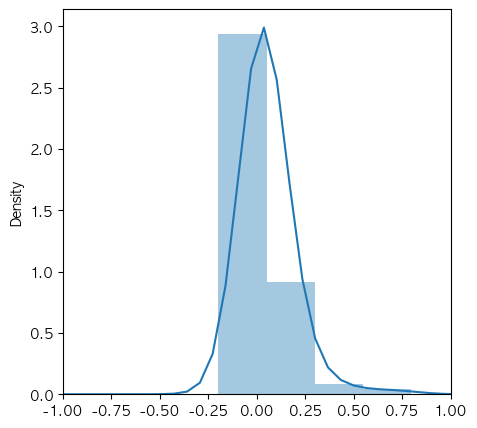

In [270]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.distplot(Nominal_PNL_df)
plt.xlim(-1, 1)
plt.show()

## Sharpe

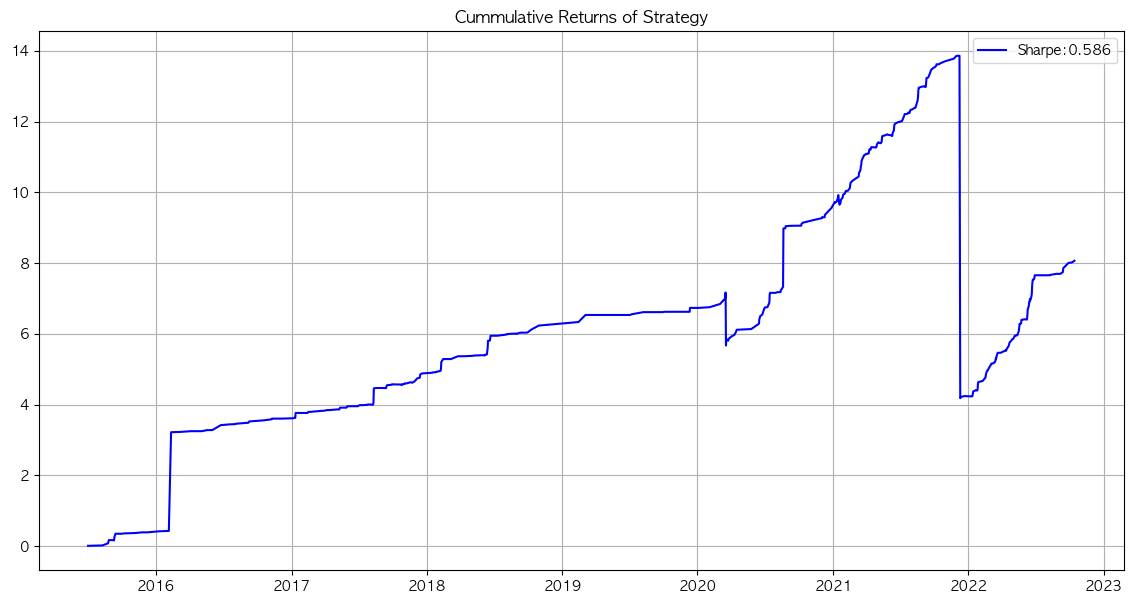

In [271]:
sharpe = (eq_pnl_df.mean() * 252 / (eq_pnl_df.std() * np.sqrt(252))).item()
plt.figure(figsize=(14,7))
plt.title('Cummulative Returns of Strategy')
plt.plot(eq_pnl_df.cumsum(), color='b', label=f'Sharpe:{np.round(sharpe, 3)}')
plt.grid()
plt.legend()
plt.show()

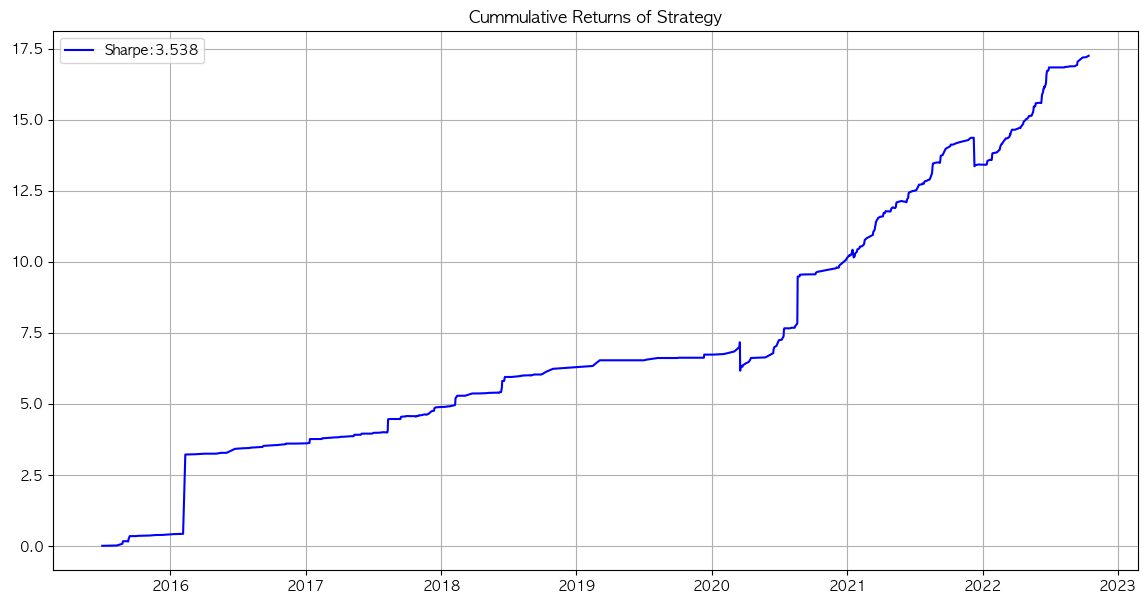

In [273]:
'''with loss cut'''

loss_cut_df = pd.DataFrame(index=eq_pnl_df.index, data=np.where(eq_pnl_df<-1, -1, eq_pnl_df), columns=['PNL'])

sharpe = (loss_cut_df.mean() * 252 / (loss_cut_df.std() * np.sqrt(252))).item()
plt.figure(figsize=(14,7))
plt.title('Cummulative Returns of Strategy')
plt.plot(loss_cut_df.cumsum(), color='b', label=f'Sharpe:{np.round(sharpe, 3)}')
plt.grid()
plt.legend()
plt.show()

## Holding 기간 보기

In [13]:
init_port = pd.DataFrame(columns=['port'])

for x in tqdm(g_reg.columns[-1816:]):

    idx = x
    s0 = kospi200.loc[idx]    

    '''필요 df'''
    check = g_reg[idx]
    p_check = p_reg[idx]
    #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''1. k범위 정하기'''
    #otm_k_c = otm_mapping(test, s0, 0.08)
    otm_k_p = otm_mapping(testp, s0, -0.08)
    atm_k = atm_mapping(testp, s0)

    check_g = g_reg[idx].iloc[np.where(g_reg[idx].index > otm_k_p)[0]].dropna()

    if len(check_g.iloc[np.where(check_g < 0)[0]]) == 0:
        pass
    else:
        
        port_list = []
        
        for new_port in check_g.iloc[np.where(check_g < 0)[0]].index:
            port_list.append(new_port)
        
        init_port.loc[idx, 'port'] = port_list

init_port_list = []

for index in init_port.index:
    for x in init_port.loc[index, 'port']:
        init_port_list.append(index.strftime('%Y%m%d') + str(x))


100%|██████████| 1816/1816 [00:20<00:00, 89.07it/s] 


In [25]:
s_list = []
p_list = []
e_list = []
h_list = []

for x in tqdm(init_port_list):
    check = x

    start_date = dt.datetime.strptime(check[0:8], '%Y%m%d')
    
    portfolio = float(check[8:])
    
    check_g = g_reg.loc[[portfolio]].T.loc[start_date:]
    end_date = check_g.iloc[np.sort(np.append(np.where( (check_g >= 0) )[0], np.where(pd.isna(check_g) == True)[0]))].index[0]
        
    holding_date = int((end_date - start_date).days)

    s_list.append(start_date)
    p_list.append(portfolio)
    e_list.append(end_date)
    h_list.append(holding_date)
    
holding_reg = pd.DataFrame(np.array([s_list, p_list, e_list, h_list]).T, columns=['Start','Port','End','Holdings'])
holding_reg

100%|██████████| 332/332 [00:00<00:00, 1386.27it/s]


,Start,Port,End,Holdings
0,2015-07-01,235.0,2015-07-02,1
1,2015-08-07,222.5,2015-08-10,3
2,2015-08-24,207.5,2015-08-26,2
3,2015-08-24,212.5,2015-08-25,1
4,2015-08-25,207.5,2015-08-26,1
...,...,...,...,...
327,2022-08-08,302.5,2022-08-09,1
328,2022-08-09,307.5,2022-08-10,1
329,2022-09-05,287.5,2022-09-06,1
330,2022-09-27,270.0,2022-09-28,1


In [26]:
holding_reg.iloc[np.where(holding_reg.Holdings > 5)[0]]

,Start,Port,End,Holdings
12,2016-02-05,220.0,2016-02-11,6
56,2017-09-29,297.5,2017-10-10,11
213,2021-06-04,405.0,2021-06-10,6
250,2021-09-17,402.5,2021-09-23,6
271,2022-01-28,330.0,2022-02-03,6


In [27]:
holding_reg.Holdings.astype(int).describe()

count    332.000000
mean       1.575301
std        1.135951
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Holdings, dtype: float64

In [217]:
holding_reg[holding_reg.End >= '2020-03-10']

,Start,Port,End,Holdings
119,2020-03-12,232.5,2020-03-13,1
120,2020-03-12,240.0,2020-03-13,1
121,2020-03-13,227.5,2020-03-16,3
122,2020-03-16,217.5,2020-03-17,1
123,2020-03-17,210.0,2020-03-18,1
...,...,...,...,...
327,2022-08-08,302.5,2022-08-09,1
328,2022-08-09,307.5,2022-08-10,1
329,2022-09-05,287.5,2022-09-06,1
330,2022-09-27,270.0,2022-09-28,1


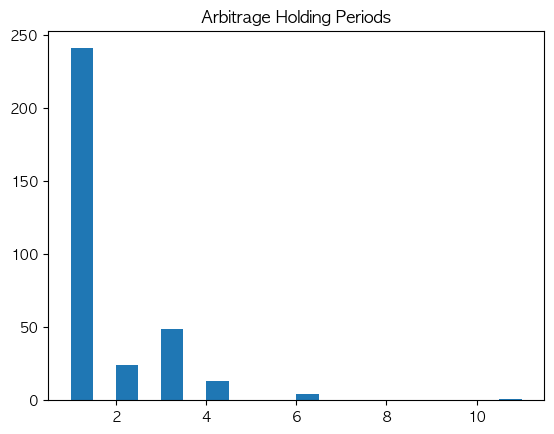

In [28]:
plt.title('Arbitrage Holding Periods')
plt.hist(holding_reg.Holdings, bins=20)
plt.show()

In [ ]:
100 * 0.078

In [86]:
holding_reg[holding_reg.Start=='2022-06-19']

,Start,Port,End,Holdings


In [76]:
holding_reg[holding_reg.Start=='2020-03-11']

,Start,Port,End,Holdings


In [75]:
holding_reg[holding_reg.Start=='2020-03-12']

,Start,Port,End,Holdings
119,2020-03-12,232.5,2020-03-13,1
120,2020-03-12,240.0,2020-03-13,1


In [82]:
p_reg['2020-03-13'].dropna()

207.5     5.02
210.0     5.57
212.5     6.08
215.0     6.61
217.5     7.11
220.0     7.84
222.5     8.61
225.0     9.28
227.5       10
230.0       11
232.5     11.8
235.0    12.75
237.5     13.7
240.0     15.7
Name: 2020-03-13 00:00:00, dtype: object

In [151]:
p_all_reg['2020-03-13'].dropna()

207.5     5.02
210.0     5.57
212.5     6.08
215.0     6.61
217.5     7.11
220.0     7.84
222.5     8.61
225.0     9.28
227.5       10
230.0       11
232.5     11.8
235.0    12.75
237.5     13.7
240.0     15.7
Name: 2020-03-13 00:00:00, dtype: object

In [70]:
holding_reg[holding_reg.Start=='2020-03-19']

,Start,Port,End,Holdings
125,2020-03-19,185.0,2020-03-20,1


In [42]:
#a = zip(holding_reg.Start, holding_reg.Port)
#for x in a:
#    print(x[0], x[1])
p_reg.loc[235.0, '2015-07-01']

0.03

In [ ]:
np.where()

In [31]:
#for x in holding_reg.index:
idx = 0
aa = holding_reg.iloc[[idx]]

s_d = aa['Start'].item()
e_d = aa['End'].item()

